In [1]:
import torch
import os
import json
import numpy as np
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import sys
from torchvision import datasets, transforms as T 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/eecs/jialin_song/anaconda3/envs/round_11/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparation

In [2]:
MODEL_FILEDIR = '/scratch/data/TrojAI/image-classification-sep2022-train/models/'
CLEAN_SAMPLE_IMG_DIR = '/scratch/data/TrojAI/image-classification-sep2022-train/image-classification-sep2022-example-source-dataset'
METADATA_FILEPATH = '/scratch/data/TrojAI/image-classification-sep2022-train/METADATA.csv'
MODEL_ARCH = ['classification:' + arch for arch in ['resnet50', 'vit_base_patch32_224', 'mobilenet_v2']]
NUM_MODEL = 288
EXTRACTED_FILEDIR = '/scratch/jialin/image-classification-sep2022/projects/trigger_inversion/extracted_source'
COLOR_CHANNEL, RESOLUTION = 3, 256

In [3]:
def num_to_model_id(num):
    return 'id-' + str(100000000+num)[1:]

In [4]:
def set_seed(seed=0):
    """Set one seed for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

## Load Metadata

In [5]:
METADATA = pd.read_csv(METADATA_FILEPATH)
METADATA.head()

,model_name,converged,nonconverged_reason,master_seed,task_type_level,task_type,source_dataset_level,source_dataset,model_architecture,model_architecture_level,...,trigger_2.trigger_size_restriction_option,trigger_2.polygon_texture_augmentation_level,trigger_2.polygon_texture_augmentation,trigger_2.size_percentage_of_foreground_min,trigger_2.size_percentage_of_foreground_max,trigger_2.min_area,trigger_2.spatial_quadrant_level,trigger_2.spatial_quadrant,trigger_2.options_level,trigger_2.options
0,id-00000000,True,NaN,354103127,0,classification,0,cityscapes,classification:resnet50,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id-00000001,True,NaN,2049821827,0,classification,0,cityscapes,classification:vit_base_patch32_224,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,id-00000002,True,NaN,74361305,0,classification,0,cityscapes,classification:mobilenet_v2,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,id-00000003,True,NaN,197593124,0,classification,0,cityscapes,classification:resnet50,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,id-00000004,True,NaN,69550395,0,classification,0,cityscapes,classification:resnet50,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Process Image

In [6]:
from itertools import product
def process_img(img_filepath, resize=False, resize_res=16, padding=False, padding_pos='middle'):
    img = cv2.imread(img_filepath, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = torch.as_tensor(img)
    image = image.permute((2, 0, 1))
    images = None
    if resize:
        resize_transforms = T.Resize(size=(resize_res, resize_res))
        image = resize_transforms(image)
    if padding:
        img_size = resize_res if resize else image.shape[0]
        if padding_pos == 'middle':
            p_trans = T.Pad(padding=(256-img_size)//2, padding_mode='constant', fill=0)
            image = p_trans(image)
        else:
            padding_transforms = []
            padding_slot = int((256-3*img_size)/6)
            mid = int((256-img_size)/2)
            positions = [mid-img_size-2*padding_slot, mid, mid+img_size+2*padding_slot]
            for left, top in list(product(positions, positions)):
                p_trans = T.Pad(padding=(left, top, 256-img_size-left, 256-img_size-top), padding_mode='constant', fill=0)
                padding_transforms.append(p_trans)
            images = []
            for p_trans in padding_transforms:
                images.append(p_trans(image))
    augmentation_transforms = T.Compose([T.ConvertImageDtype(torch.float)]) 
    if images:
        return [augmentation_transforms(image) for image in images]
    return augmentation_transforms(image)

## Test on MobileNetV2

In [7]:
model_ids = METADATA[METADATA['model_architecture']==MODEL_ARCH[2]]['model_name'].tolist()

In [8]:
model_ids[0]

'id-00000002'

In [9]:
poisoned_model_id = METADATA[METADATA['poisoned']]['model_name'].tolist()

In [10]:
all_train_triggers = []
for p_model_id in poisoned_model_id:
    model_dir = os.path.join(MODEL_FILEDIR, p_model_id)
    for potential_img_path in os.listdir(model_dir):
        if potential_img_path.startswith('trigger') and potential_img_path.endswith('png'):
            processed_triggers = process_img(os.path.join(model_dir, potential_img_path), resize=True, resize_res=16, padding=True, padding_pos='arr')
            all_train_triggers.extend(processed_triggers)

In [11]:
all_train_triggers = torch.stack(all_train_triggers, dim=0)

In [12]:
rand_num_for_filter = (1.8-.2)*torch.rand(2000-all_train_triggers.shape[0], 3)+.2

In [13]:
rand_num_for_filter = rand_num_for_filter.expand(256, 256, -1, -1).permute(2, 3, 0, 1)

In [12]:
trigger_size, filter_size = all_train_triggers.shape[0], rand_num_for_filter.shape[0]

In [13]:
trigger_size, filter_size

(1476, 524)

In [16]:
np.save(os.path.join(EXTRACTED_FILEDIR, 'all_train_triggers.npy'), all_train_triggers.numpy())
np.save(os.path.join(EXTRACTED_FILEDIR, 'rand_num_for_filter.npy'), rand_num_for_filter.numpy())

In [14]:
all_train_triggers.shape, rand_num_for_filter.shape

(torch.Size([1476, 3, 256, 256]), torch.Size([524, 3, 256, 256]))

In [10]:
learned_param_path = '/scratch/jialin/image-classification-sep2022/projects/weight_analysis/for_container/learned_parameters'

In [11]:
all_train_triggers = torch.from_numpy(np.load(os.path.join(learned_param_path, 'all_train_triggers.npy')))
rand_num_for_filter = torch.from_numpy(np.load(os.path.join(learned_param_path, 'rand_num_for_filter.npy')))

In [12]:
trigger_size, filter_size = all_train_triggers.shape[0], rand_num_for_filter.shape[0]

In [13]:
trigger_size, filter_size

(1476, 524)

In [13]:
def extract_stats(loss_arr, tri_size=164, loop_range=13):
    stats = []
    for i in range(loop_range):
        if i >= 9:
            start_from = 9*tri_size
            interval = (loss_arr.shape[-1] - start_from)//(loop_range-9)
            extracted_loss = loss_arr[:, start_from+(i-9)*interval:start_from+(i-9+1)*interval]
        else:
            ind = [i+9*j for j in range(tri_size)]
            extracted_loss = loss_arr[:, ind]
        stats.extend([np.mean(extracted_loss), np.median(extracted_loss), np.std(extracted_loss), np.max(extracted_loss)])
    return stats

for each batch_size*trigger, extracting mean, median, std, max;
having triggers:[9 insert positions for polygon trigger, 1 ins-filter trigger]

In [17]:
device = torch.device('cuda:1')
prob_dict = {}
batch_size = 40
train_trigger_size = 164
# for model_id in tqdm(METADATA['model_name'].tolist()):
for model_id in tqdm(model_ids):
    model_dir = os.path.join(MODEL_FILEDIR, model_id)
    clean_sample_dir = os.path.join(model_dir, 'clean-example-data')
    with torch.no_grad():
        model = torch.load(os.path.join(model_dir, 'model.pt')).to(device)
        model.eval()

    probs = {'clean':[], 'trojan':[]}
    for clean_image in os.listdir(clean_sample_dir):
        if clean_image.endswith('png'):
            processed_image = process_img(os.path.join(clean_sample_dir, clean_image))
            with torch.no_grad():
                logits = model(processed_image.unsqueeze(dim=0).to(device))
                clean_prob = F.softmax(logits, dim=1).tolist()
            probs['clean'].append(clean_prob)
            expanded_image = processed_image.expand(batch_size, -1, -1, -1)
            trojan_prob_per_img = []
            for i in range((trigger_size+filter_size)//batch_size):
                s_ind, e_ind = batch_size*i, batch_size*(i+1)
                if e_ind < trigger_size:
                    polygon_triggers = all_train_triggers[s_ind:e_ind, :]
                    images = torch.where(polygon_triggers==0, expanded_image, polygon_triggers)
                elif s_ind < trigger_size and e_ind > trigger_size:
                    polygon_triggers = all_train_triggers[s_ind:, :]
                    poly_images = torch.where(polygon_triggers==0, expanded_image[polygon_triggers.shape[0], :], polygon_triggers)
                    filter_triggers = rand_num_for_filter[:e_ind-trigger_size, :]
                    filter_images = torch.clip(filter_triggers*expanded_image[batch_size-filter_triggers.shape[0], :], 0, 1)
                    images = torch.concat([poly_images, filter_images], dim=0)
                else:
                    filter_triggers = rand_num_for_filter[s_ind-trigger_size:e_ind-trigger_size, :]
                    images = torch.clip(filter_triggers*expanded_image, 0, 1)
                with torch.no_grad():
                    logits = model(images.to(device))
                    trojan_prob = F.softmax(logits, dim=1).tolist()
                    trojan_prob_per_img += trojan_prob
            probs['trojan'].append(trojan_prob_per_img)
    # prob_dict[model_id] = extract_stats(np.asarray(probs))
    prob_dict[model_id] = probs

100%|██████████| 96/96 [1:29:33<00:00, 55.97s/it]


In [19]:
with open(os.path.join(EXTRACTED_FILEDIR, f'prob_stats_dict_{MODEL_ARCH[2][15:]}.json'), 'w') as outfile:
    json.dump(prob_dict, outfile)

## Visualization

In [12]:
with open(os.path.join(EXTRACTED_FILEDIR, f'prob_stats_dict_{MODEL_ARCH[2][15:]}.json'), 'r') as outfile:
    prob_dict = json.load(outfile)

In [20]:
import pandas as pd
import seaborn as sns

In [21]:
for k, v in prob_dict.items():
    for kk, vv in v.items():
        print(np.asarray(vv).shape)
    break

(20, 1, 118)
(20, 2000, 118)


In [66]:
poisoned_model_ids = METADATA[METADATA['poisoned']]['model_name'].tolist()

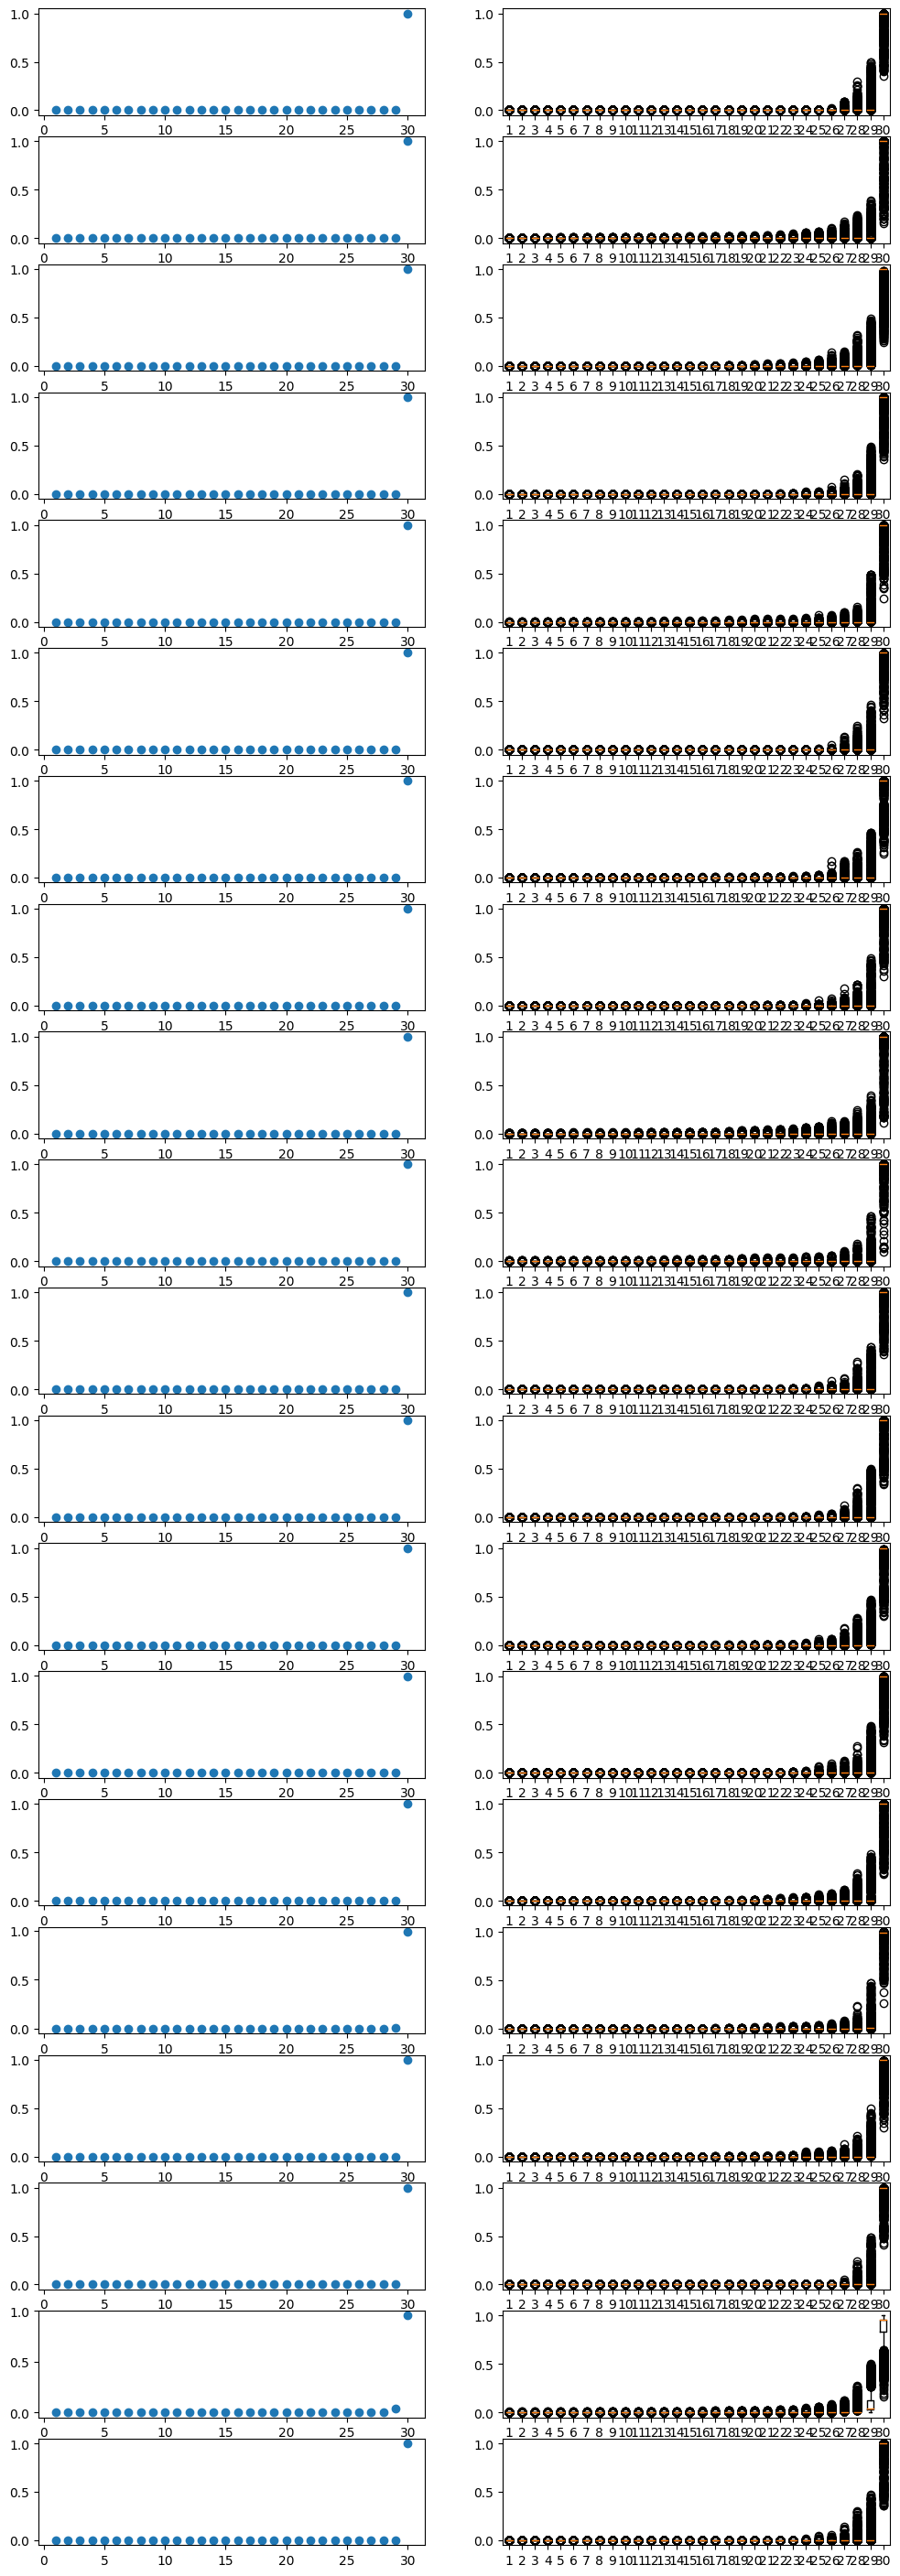

In [62]:
k = 'id-00000002'
fig, ax = plt.subplots(figsize=(12, 36), ncols=2, nrows=20)
clean = np.sort(prob_dict[k]['clean'], axis=-1)
trojan = np.sort(prob_dict[k]['trojan'], axis=-1)
for r in range(20):
    ax[r, 0].scatter(range(1, 31), clean[r, :, -30:]);
    ax[r, 1].boxplot(trojan[r, :, -30:]);

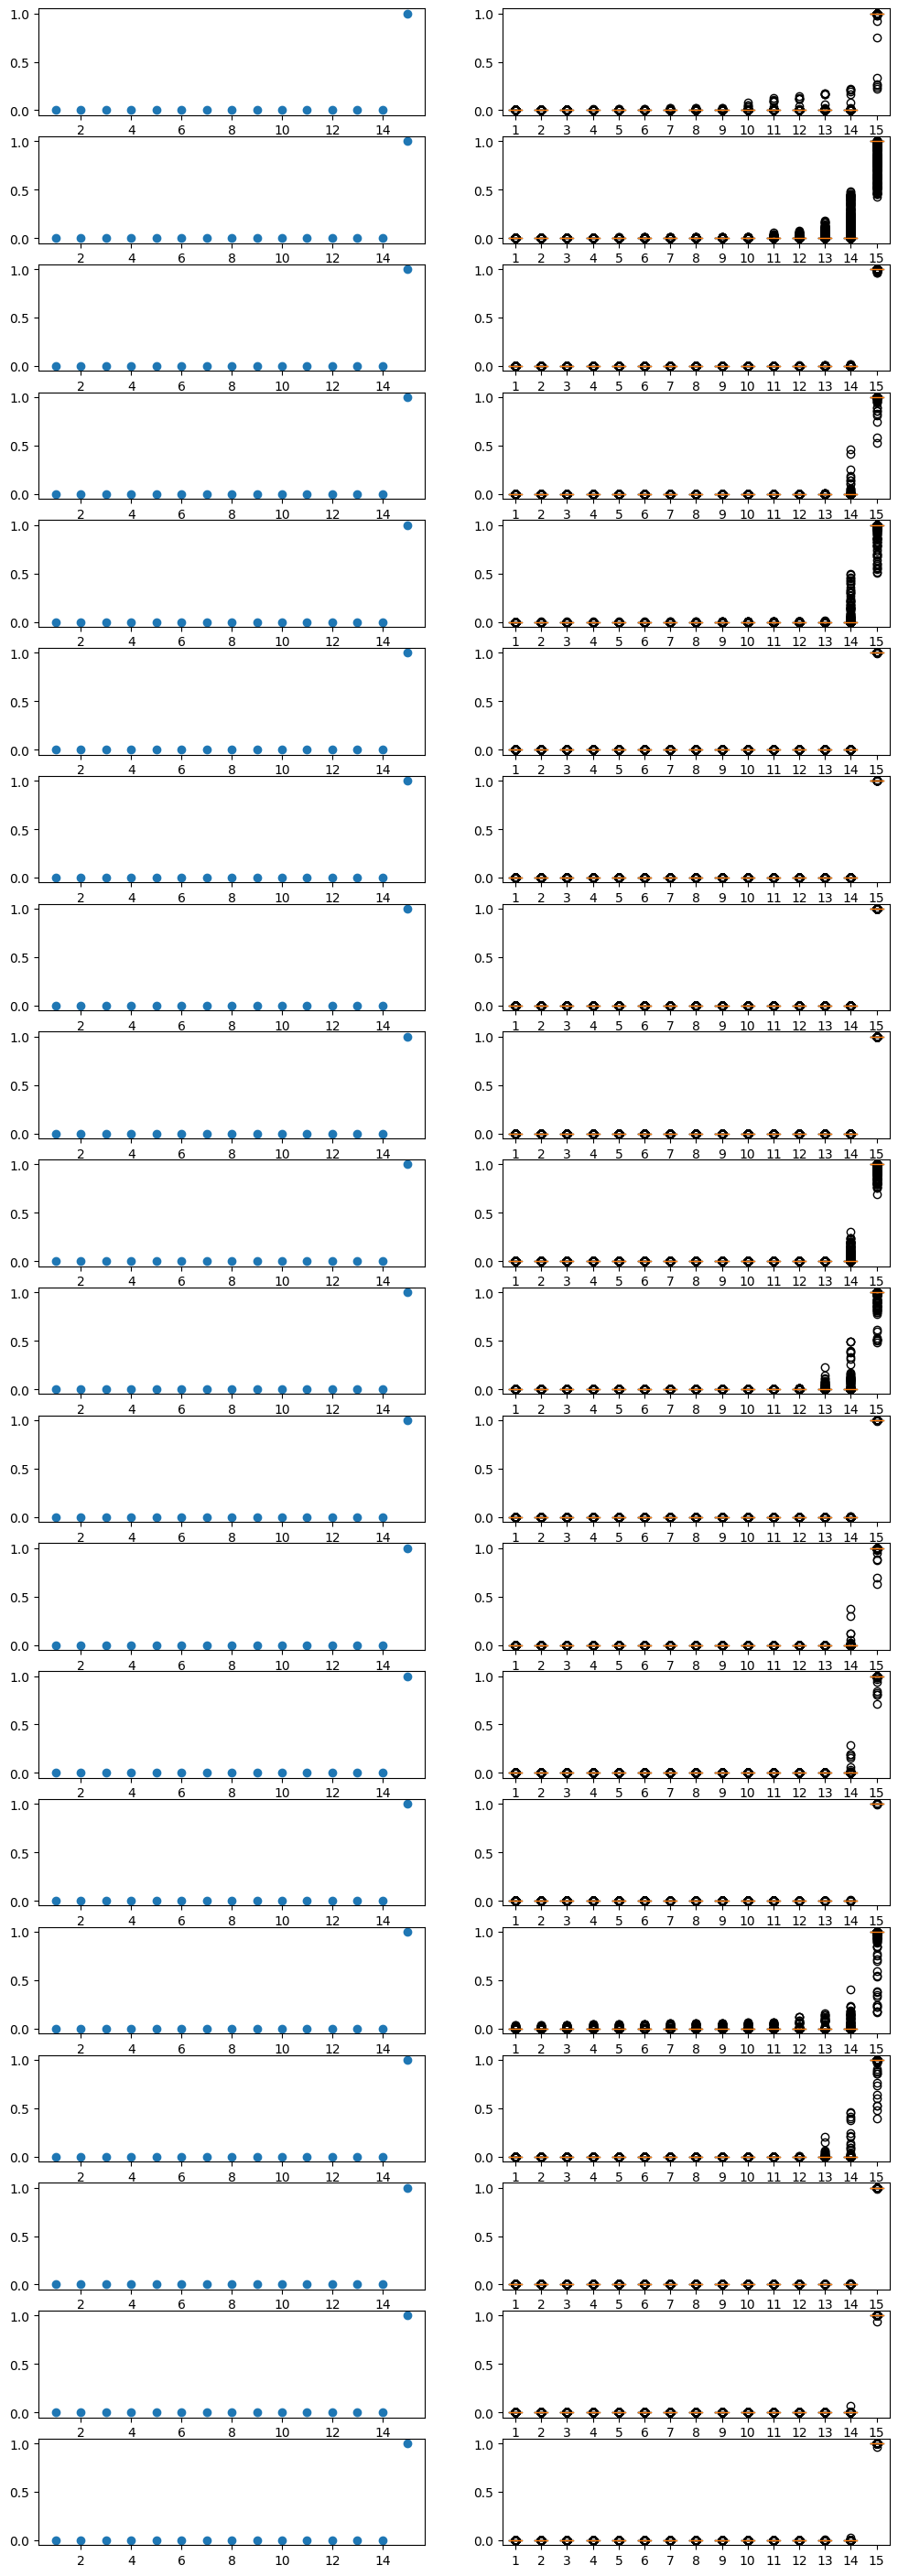

In [65]:
k = 'id-00000035'
fig, ax = plt.subplots(figsize=(12, 36), ncols=2, nrows=20)
clean = np.sort(prob_dict[k]['clean'], axis=-1)
trojan = np.sort(prob_dict[k]['trojan'], axis=-1)
for r in range(20):
    ax[r, 0].scatter(range(1, 16), clean[r, :, -30:]);
    ax[r, 1].boxplot(trojan[r, :, -30:]);

In [78]:
cot_prob = {f'{cot1}_image_{cot2}_model':[] for cot1, cot2 in list(product(['clean', 'trojan'], ['clean', 'trojan']))}
for k, v in prob_dict.items():
    for kk, vv in v.items():
        sort_v = np.sort(vv, axis=-1)[:, :, -30:]
        if sort_v.shape[-1] < 30:
            img_size = 2000 if kk == 'trojan' else 1
            sort_v = np.concatenate([np.zeros((20, img_size, 30-sort_v.shape[-1])), sort_v], axis=-1)
        cot_model = 'trojan' if k in poisoned_model_ids else 'clean'
        cot_prob[f'{kk}_image_{cot_model}_model'].append(sort_v)
for k, v in cot_prob.items():
    cot_prob[k] = np.concatenate(v, axis=0)

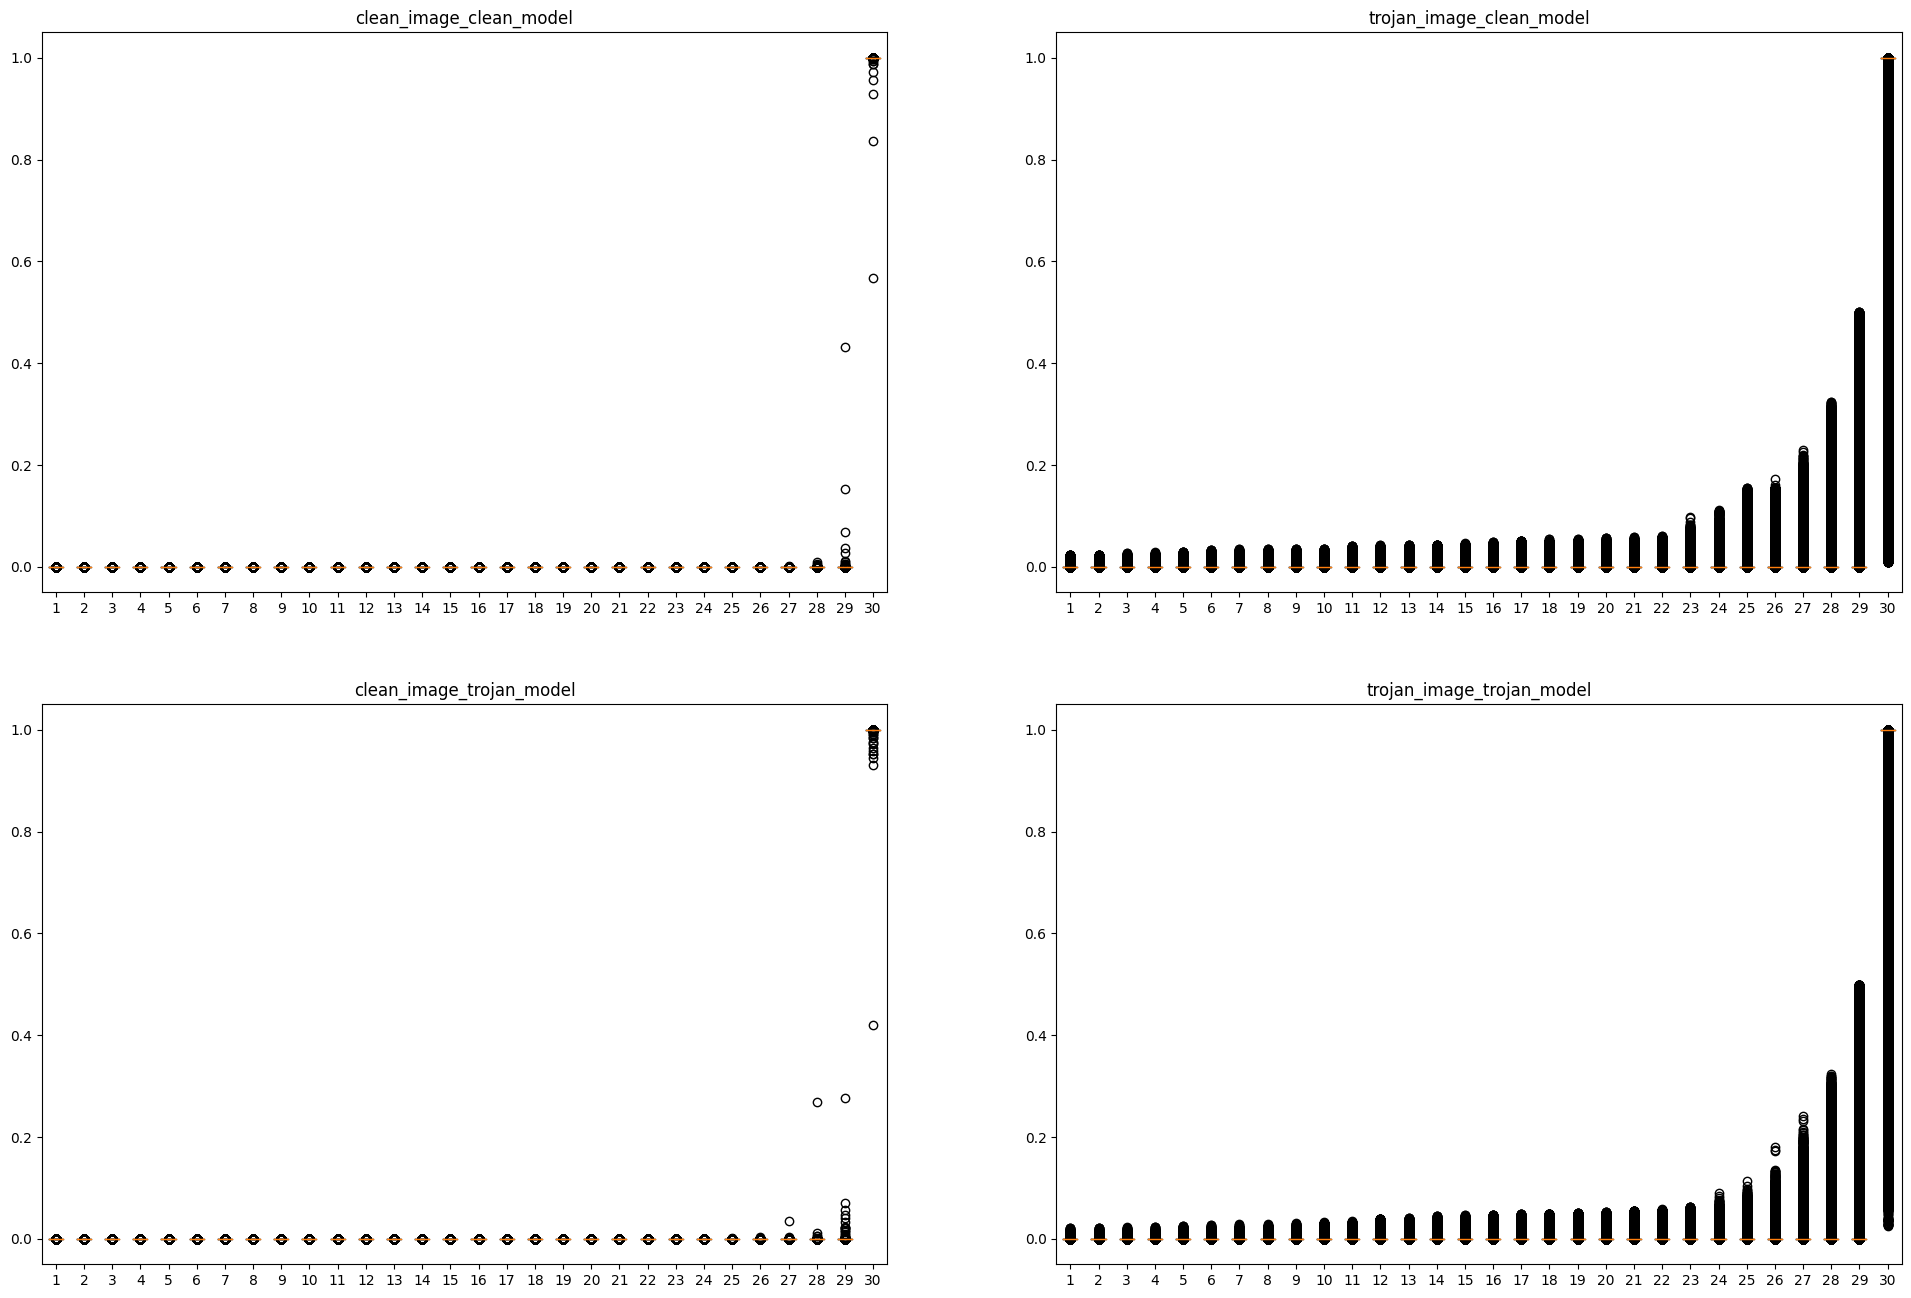

In [79]:
fig, ax = plt.subplots(figsize=(24, 16), ncols=2, nrows=2)
for ind, (k, v) in enumerate(cot_prob.items()):
    ax[ind % 2, ind // 2].boxplot(v.reshape(-1, 30));
    ax[ind % 2, ind // 2].set_title(k)